In [7]:
using Plots, Interpolations, Polynomials, LinearAlgebra,Statistics,DataFrames,Measures

## Zadanie 1 - interpolacja wielomianem Lagrange'a

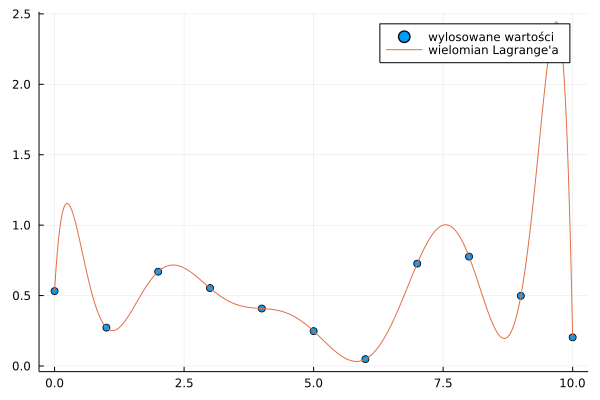

In [8]:
function Lagrange(xsf,ysf,s)
    P = 0
    len = size(xsf)[1]
    for i in 1:len
        L = 1
        for j in 1:len
            if j != i
                L *= (s-xsf[j])/(xsf[i]-xsf[j])
            end
        end
        P += (ysf[i]*L)
    end
    return P
end
xsf = 0:1:10
ysf = [rand() for x in xsf]
test = 0:0.01:10
dopasowanie = [Lagrange(xsf,ysf,x) for x in test]
scatter(xsf,ysf,label="wylosowane wartości")
plot!(test,dopasowanie,label="wielomian Lagrange'a",legend_postion=:topright)

## Zadanie 2 - interpolacja metodą ilorazów różnicowych

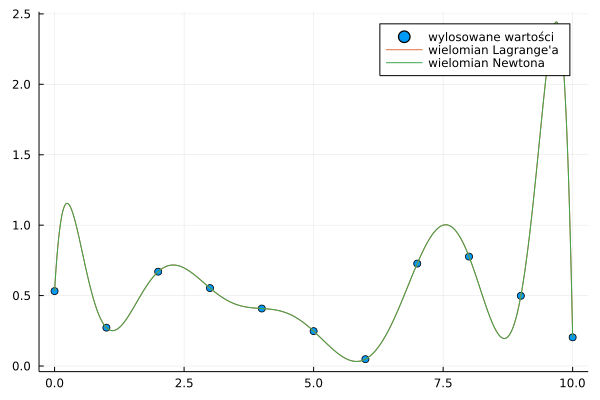

In [9]:
function NewtonInterpolation(xsf, ysf)
    T = Float64[]
    n = size(xsf)[1]
    for a in 1:n
        push!(T,ysf[a])
        for i in 1:a-1
            nom = T[end]-T[end-a+1]
            den = xsf[a] - xsf[a-i]
            push!(T,nom/den)
        end
    end
    newt = Float64[]
    k = 0
    for i in 1:n
        k = k + i
        push!(newt,T[k])
    end
    return newt
end

function Newton(newt,xsf,x)
    n = size(xsf)[1]
    b = newt[n]
    for i=1:n-1
        b = newt[n-i] + b*(x-xsf[n-i])
    end
    return b
end
table = NewtonInterpolation(xsf,ysf)
newton = [Newton(table,xsf,x) for x in test]
plot!(test,newton,label="wielomian Newtona")

## Zadanie 3 - interpolacja pakietem Polynomials

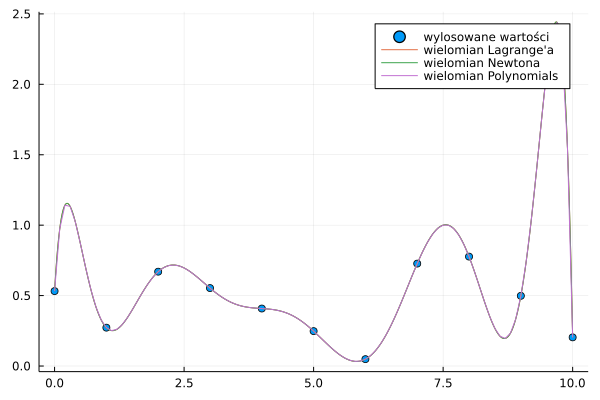

In [10]:
f=fit(xsf, ysf)
plot!(f, extrema(xsf)...,label="wielomian Polynomials")

Co ciekawe, wszystkie interpolacje właściwie się pokrywają (jedyne różnica można dostrzec na przegięciach funkcji). Wynika to z twierdzenia, które mówi, że istnieje tylko 1 wielomian n-tego stopnia przechodzący przez punkty.

## Zadanie 4 - porównanie czasów interpolacji

In [11]:
df = DataFrame(Nodes=Int[],Lagr=Float64[],Newt1=Float64[],Newt2=Float64[],Polyn1=Float64[],Polyn2=Float64[])
for i in 10:100:1000
    for j in 1:12
        width = 10/i
        x_axis = 0:width:10
        y_axis = [rand() for x in x_axis]
        test = 0:0.01:10
        lagr, time1 = @timed [Lagrange(x_axis,y_axis,x) for x in test]
        newt, time2 = @timed NewtonInterpolation(x_axis, y_axis)
        newt2, time3 = @timed[Newton(newt,x_axis,x) for x in test]
        polyn, time4 = @timed fit(x_axis,y_axis)
        polyn2, time5 = @timed [polyn(x) for x in test]
        if j > 2
            push!(df,(i,time1,time2,time3,time4,time5))
        end
    end
end

In [12]:
df2 = combine(groupby(df,:Nodes),:Lagr => mean => :m1,:Lagr => std => :s1,
    :Newt1 => mean => :m2, :Newt1 => std => :s2,
    :Newt2 => mean => :m3, :Newt2 => std => :s3,
    :Polyn1 => mean => :m4, :Polyn1 => std => :s4,
    :Polyn2 => mean => :m5, :Polyn2 => std => :s5)

,Nodes,m1,s1,m2,s2,m3,s3
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,10,0.00118913,0.0003135,6.0845e-6,1.37295e-6,8.49107e-5,1.95438e-5
2,110,0.109856,0.0045786,0.000266681,5.7531e-5,0.000785751,0.000193077
3,210,0.36463,0.00500176,0.00500554,0.0135442,0.00133461,0.000190954
4,310,0.813148,0.0250923,0.00182407,0.000469793,0.00196258,0.000194137
5,410,1.40203,0.0248771,0.00314416,1.59111e-5,0.00244685,2.86873e-5
6,510,2.14351,0.0415511,0.00457304,0.000220285,0.00302524,2.16224e-5
7,610,3.08571,0.0337474,0.00922967,0.00778538,0.00368664,0.000115683
8,710,4.48292,0.0583736,0.00749901,0.000754593,0.00475391,0.000959624
9,810,6.06624,0.0745891,0.0110378,0.00286418,0.00479382,0.000114794


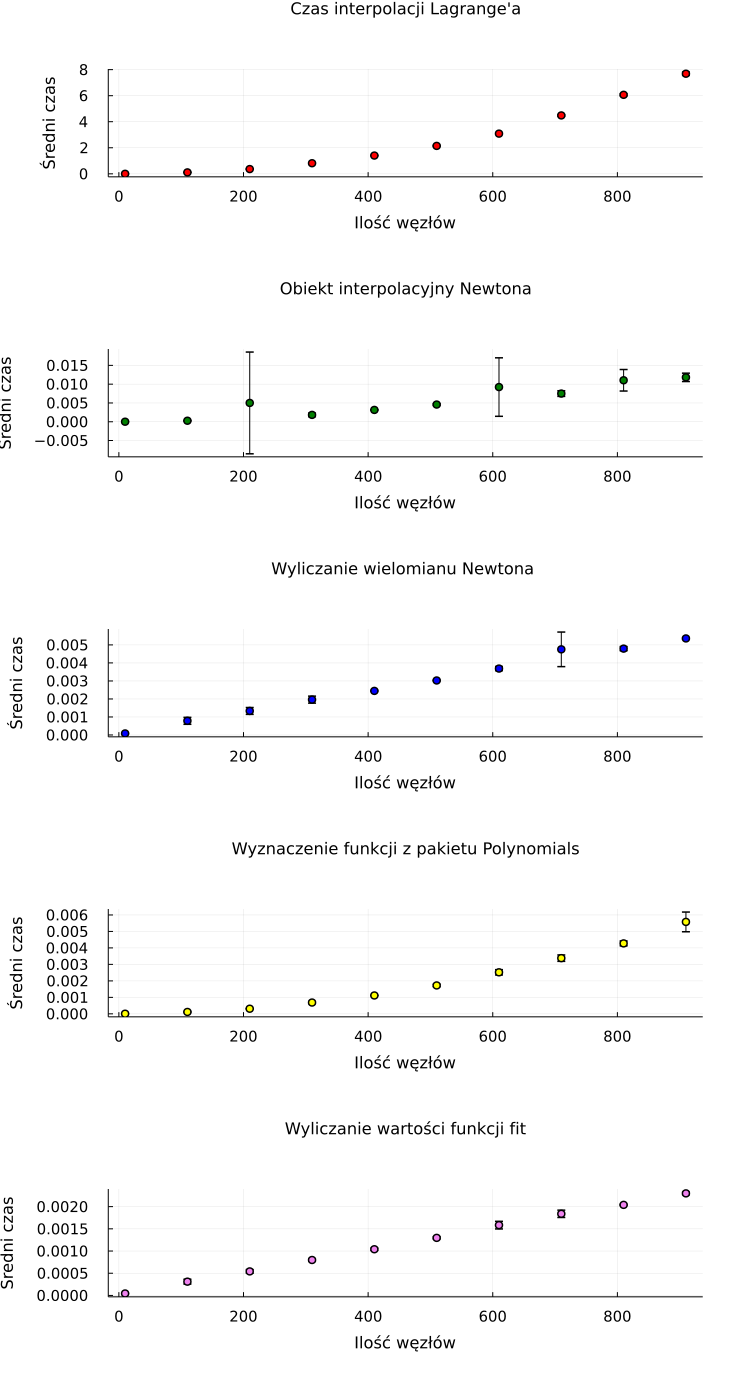

In [13]:
scatter(
    df2.Nodes, 
    size = (750, 1400), 
    margin=10mm,
    xtickfontsize=10, 
    ytickfontsize=10, 
    titlefontsize = 11,
    xlabel = "Ilość węzłów",
    ylabel = "Średni czas",
    [df2.m1,df2.m2,df2.m3,df2.m4,df2.m5], 
    title = ["Czas interpolacji Lagrange'a" "Obiekt interpolacyjny Newtona" "Wyliczanie wielomianu Newtona " "Wyznaczenie funkcji z pakietu Polynomials" "Wyliczanie wartości funkcji fit"], 
    color = [:red :green :blue :yellow :violet],
    yerr = [df2.s1 df2.s2 df2.s3 df2.s4 df2.s5], 
    layout = grid(5,1),
    legend = false
)

## Zadanie 5 - Algorytm Neville'a


In [14]:
xsf = 0:1:10
ysf = [rand() for x in xsf]
function Neville(xsf,ysf,x)
    n = size(xsf)[1]
    t = zeros(Float64,n,n)
    for i in 1:n
        t[i,1] = ysf[i]
    end
    for i=2:n
        for k=i:n
            t[k,i] = ((x-xsf[k])*t[k-1,i-1] - (x-xsf[k-i+1])*t[k,i-1])/(xsf[k-i+1]-xsf[k])
        end
    end
    return t[n,n]
end
tests = [1.5,2.77,3.543,9.8,6.66]
println("Neville\t\t   Lagrange\t\tróżnica")
for test in tests
    print(Neville(xsf,ysf,test),"  ",Lagrange(xsf,ysf,test),"  ",abs(Neville(xsf,ysf,test)-Lagrange(xsf,ysf,test)),"\n")
end

Neville		   Lagrange		różnica
1.377729771416651  1.377729771416651  0.0
0.3620205525375084  0.3620205525375083  1.1102230246251565e-16
0.9554595749912714  0.9554595749912713  1.1102230246251565e-16
-4.601032671056691  -4.601032671056692  8.881784197001252e-16
0.814431429734827  0.814431429734827  0.0


## Zadanie 6 - efekt Rungego

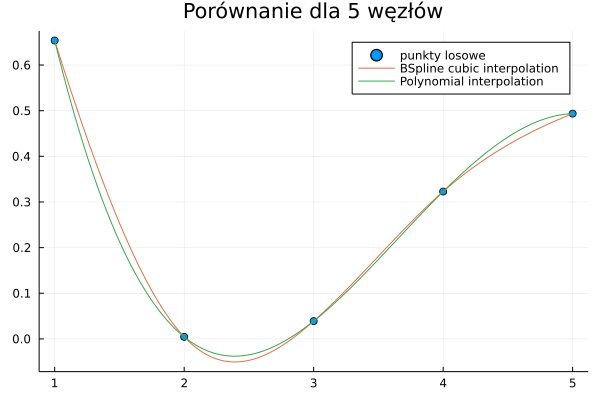

In [15]:
xs = 1:5
ys = [rand() for x in xs]
xsf = 1:0.01:5
scatter(xs,ys,label="punkty losowe")
f1 = interpolate(ys, BSpline(Cubic(Natural(OnCell()))))
ysf1=[f1(x) for x in xsf]
plot!(xsf,ysf1, label="BSpline cubic interpolation")
f2 = fit(xs,ys)
ysf2=[f2(x) for x in xsf]
plot!(xsf,ysf2, label="Polynomial interpolation", title="Porównanie dla 5 węzłów")


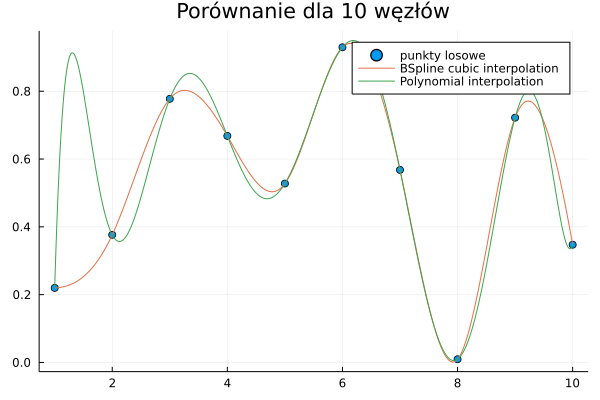

In [16]:
xs2 = 1:10
ys2 = [rand() for x in xs2]
xsf2 = 1:0.01:10
scatter(xs2,ys2,label="punkty losowe")
f3 = interpolate(ys2, BSpline(Cubic(Natural(OnCell()))))
ysf3=[f3(x) for x in xsf2]
plot!(xsf2,ysf3, label="BSpline cubic interpolation")
f4 = fit(xs2,ys2)
ysf4=[f4(x) for x in xsf2]
plot!(xsf2,ysf4, label="Polynomial interpolation", title="Porównanie dla 10 węzłów")

Nie trudno zauważyć, że interpolacja z pakietu Polynomials jest dokładniejsza w drugim przypadku. Wynika to z efektu Rungego, czyli utraty dokładności odwzorowania wielomianu dla dużej liczby węzłów (szczególnie jest to widoczne na końcach przedziału)